In [2]:
import joblib
import pandas as pd
import os

df = pd.read_csv("../data/processed/dataset_entrenamiento_final_final.csv")
df.head()

target = "conteo_delitos" # columna objetivo
from sklearn.model_selection import train_test_split

X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
from xgboost import XGBRegressor

model = XGBRegressor(
    n_estimators=400,
    max_depth=8,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    objective="reg:squarederror"
)

model.fit(X_train, y_train)
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5

print("RMSE:", rmse)

# GUARDAR EL MODELO
os.makedirs("../models/trained", exist_ok=True)
joblib.dump(model, "../models/trained/modelo_riesgo_delictivo.pkl")




RMSE: 0.32505139898126156


['../models/trained/modelo_riesgo_delictivo.pkl']

Modelo cargado correctamente.

IMPORTANCIA DE VARIABLES (GAIN)
                  feature  importance
5   conteo_delitos_graves  403.398895
6  conteo_llamadas_riesgo   89.039856
0                lat_grid   21.086567
4              dia_semana   19.338385
3                     dia   18.905947
1                lon_grid   13.401047
2                     mes   12.823771


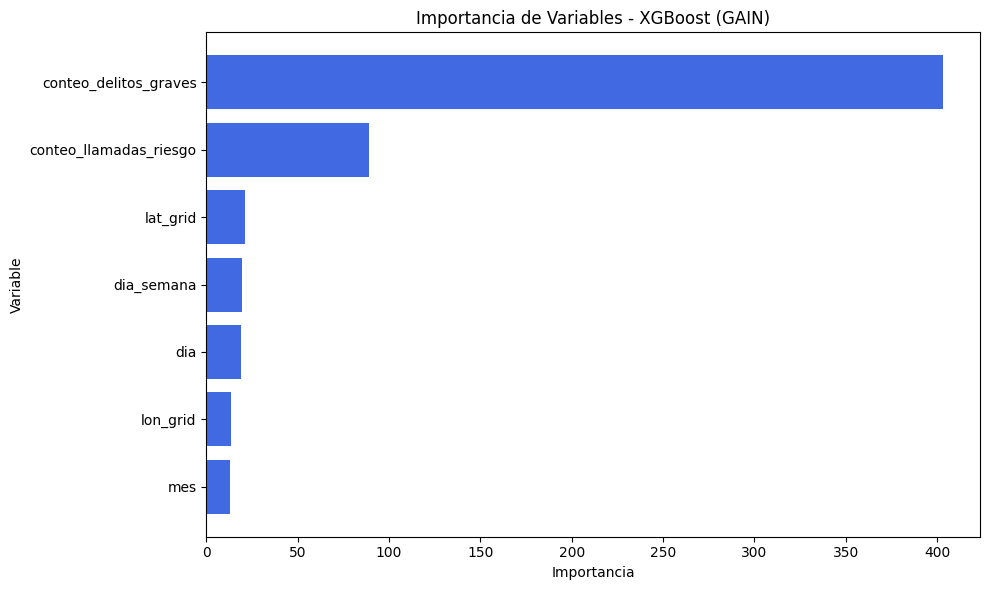

In [3]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# ============================================================
# 1. CARGAR EL MODELO ENTRENADO DESDE ARCHIVO
# ============================================================

modelo = joblib.load("../models/trained/modelo_riesgo_delictivo.pkl")

print("Modelo cargado correctamente.")

# ============================================================
# 2. OBTENER IMPORTANCIA DE VARIABLES (XGBoost GAIN)
# ============================================================

booster = modelo.get_booster()
importance = booster.get_score(importance_type='gain')

df_importance = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
})

df_importance = df_importance.sort_values(by='importance', ascending=False)

print("\n==============================")
print("IMPORTANCIA DE VARIABLES (GAIN)")
print("==============================")
print(df_importance)

# ============================================================
# 3. GRAFICAR IMPORTANCIA DE VARIABLES
# ============================================================

plt.figure(figsize=(10, 6))
plt.barh(df_importance["feature"], df_importance["importance"], color="royalblue")
plt.gca().invert_yaxis()
plt.title("Importancia de Variables - XGBoost (GAIN)")
plt.xlabel("Importancia")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()


In [6]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    roc_curve, precision_recall_curve, brier_score_loss,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import numpy as np

In [7]:

# ---------------------------
# Utilidades
# ---------------------------
def _safe_predict_proba(model, X):
    """Devuelve probas de clase positiva si existe predict_proba; si no, intenta decision_function."""
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        # binario: (n,2) -> columna 1
        if proba.ndim == 2 and proba.shape[1] >= 2:
            return proba[:, 1]
        # ya viene como (n,)
        return proba
    raise ValueError("El modelo no tiene predict_proba(). Para clasificación, usa XGBClassifier.")

def _plot_curve(x, y, xlabel, ylabel, title):
    plt.figure()
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

def buscar_threshold_por_recall(model, X_val, y_val, recall_objetivo=0.90):
    """
    Busca un threshold que logre al menos recall_objetivo en val (si es posible),
    priorizando el threshold más alto (menos agresivo) que cumpla el objetivo.
    """
    p = _safe_predict_proba(model, X_val)

    # thresholds candidatos: percentiles -> rápido y suficiente
    candidatos = np.unique(np.quantile(p, np.linspace(0, 1, 200)))
    candidatos = np.clip(candidatos, 0, 1)

    mejor = None
    for thr in sorted(candidatos, reverse=True):
        yhat = (p >= thr).astype(int)
        cm = confusion_matrix(y_val, yhat, labels=[0,1])
        tn, fp, fn, tp = cm.ravel()
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        alert_rate = yhat.mean()
        if recall >= recall_objetivo:
            mejor = (thr, recall, precision, alert_rate, cm)
            break

    if mejor is None:
        # Si no se llega al recall objetivo, devuelve el mejor recall posible (thr bajo)
        best_recall = -1
        best = None
        for thr in sorted(candidatos):
            yhat = (p >= thr).astype(int)
            cm = confusion_matrix(y_val, yhat, labels=[0,1])
            tn, fp, fn, tp = cm.ravel()
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            alert_rate = yhat.mean()
            if recall > best_recall:
                best_recall = recall
                best = (thr, recall, precision, alert_rate, cm)
        thr, recall, precision, alert_rate, cm = best
        print(f"No se alcanzó recall objetivo={recall_objetivo:.2f}. Mejor recall={recall:.4f} con thr={thr:.6f}")
        return {"threshold": thr, "recall": recall, "precision": precision, "alert_rate": alert_rate, "confusion": cm}

    thr, recall, precision, alert_rate, cm = mejor
    print(f"Threshold encontrado thr={thr:.6f} | recall={recall:.4f} | precision={precision:.4f} | alert_rate={alert_rate:.4f}")
    return {"threshold": thr, "recall": recall, "precision": precision, "alert_rate": alert_rate, "confusion": cm}


# ---------------------------
# Evaluación: Regresión
# ---------------------------
def evaluar_regresion(
    model,
    X_train, y_train,
    X_val, y_val,
    titulo="Modelo Regresión"
):
    """
    Evaluación:
    - MAE, RMSE, R2 (train/val)
    - Gráfico pred vs real (val)
    - Residuales (val)
    """
    pred_tr = model.predict(X_train)
    pred_va = model.predict(X_val)

    mae_tr = mean_absolute_error(y_train, pred_tr)
    mae_va = mean_absolute_error(y_val, pred_va)

    rmse_tr = np.sqrt(mean_squared_error(y_train, pred_tr))
    rmse_va = np.sqrt(mean_squared_error(y_val, pred_va))

    r2_tr = r2_score(y_train, pred_tr)
    r2_va = r2_score(y_val, pred_va)

    print("="*70)
    print(titulo)
    print("-"*70)
    print(f"MAE   train={mae_tr:.4f} | val={mae_va:.4f}")
    print(f"RMSE  train={rmse_tr:.4f} | val={rmse_va:.4f}")
    print(f"R2    train={r2_tr:.4f} | val={r2_va:.4f}")
    print("="*70)

    # Pred vs Real (val)
    plt.figure()
    plt.scatter(y_val, pred_va, s=10)
    minv = float(min(y_val.min(), pred_va.min()))
    maxv = float(max(y_val.max(), pred_va.max()))
    plt.plot([minv, maxv], [minv, maxv], linestyle="--")
    plt.xlabel("Real")
    plt.ylabel("Predicho")
    plt.title("Predicho vs Real (val)")
    plt.grid(True)
    plt.show()

    # Residuales (val)
    resid = y_val - pred_va
    plt.figure()
    plt.scatter(pred_va, resid, s=10)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Predicho")
    plt.ylabel("Residual (real - predicho)")
    plt.title("Residuales (val)")
    plt.grid(True)
    plt.show()

    return {
        "mae_train": mae_tr, "mae_val": mae_va,
        "rmse_train": rmse_tr, "rmse_val": rmse_va,
        "r2_train": r2_tr, "r2_val": r2_va,
    }

Modelo Regresión
----------------------------------------------------------------------
MAE   train=0.1030 | val=0.1040
RMSE  train=0.3070 | val=0.3107
R2    train=0.9662 | val=0.9656


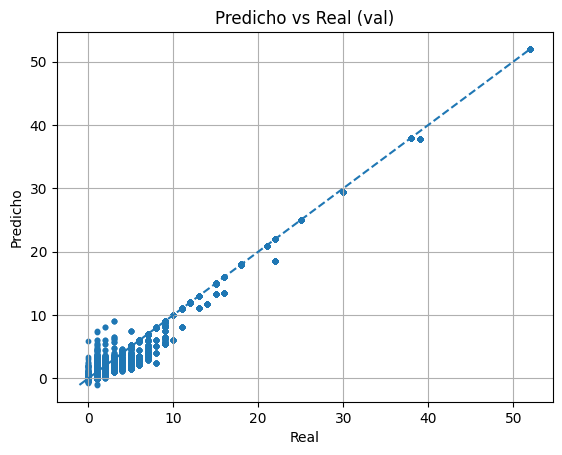

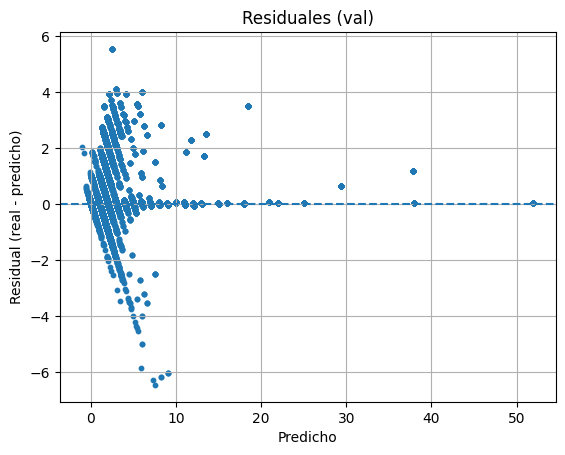

{'mae_train': 0.10298176854848862, 'mae_val': 0.10402995347976685, 'rmse_train': np.float64(0.3070375097282156), 'rmse_val': np.float64(0.31072390806475997), 'r2_train': 0.9662366509437561, 'r2_val': 0.9655539989471436}


In [8]:
metrics_reg = evaluar_regresion(modelo, X_train, y_train, X, y)

print(metrics_reg)

In [23]:
import joblib
import pandas as pd
import os

df = pd.read_csv("../data/processed/dataset_entrenamiento_final_final.csv")

df["evento_delictivo_grave"] = (df["conteo_delitos_graves"] > 0).astype(int)

df.head()

,lat_grid,lon_grid,mes,dia,dia_semana,conteo_delitos,conteo_delitos_graves,conteo_llamadas_riesgo,evento_delictivo_grave
0,-4.978,-79.116,5,6,1,1,1,0,1
1,-4.977,-79.101,10,15,2,1,1,0,1
2,-4.977,-79.100,10,15,2,1,1,0,1
3,-4.976,-79.115,8,17,6,1,0,0,0
4,-4.959,-79.121,2,1,5,0,0,1,0


In [24]:
df["fecha_dt"] = pd.to_datetime(
    dict(year=2025, month=df["mes"], day=df["dia"]),
    errors="coerce"
)

df = df.dropna(subset=["fecha_dt"])
df = df.sort_values("fecha_dt")

df.head(15)

,lat_grid,lon_grid,mes,dia,dia_semana,conteo_delitos,conteo_delitos_graves,conteo_llamadas_riesgo,evento_delictivo_grave,fecha_dt
198609,1.147,-78.765,1,1,2,0,0,2,0,2025-01-01
77664,-1.753,-78.557,1,1,2,1,1,0,1,2025-01-01
102544,-1.276,-78.585,1,1,2,0,0,5,0,2025-01-01
165896,-0.072,-79.393,1,1,2,0,0,1,0,2025-01-01
84750,-1.637,-78.616,1,1,2,0,0,1,0,2025-01-01
143012,-0.374,-78.370,1,1,2,0,0,5,0,2025-01-01
28941,-2.928,-78.779,1,1,2,0,0,2,0,2025-01-01
41719,-2.477,-79.403,1,1,2,0,0,6,0,2025-01-01
76138,-1.791,-79.532,1,1,2,1,0,0,0,2025-01-01
11626,-3.716,-79.619,1,1,2,0,0,4,0,2025-01-01


In [25]:
from xgboost import XGBClassifier

features = [
  "lat_grid",
  "lon_grid",
  "mes",
  "dia",
  "dia_semana",
  "conteo_llamadas_riesgo"
]

In [26]:
split_date = df["fecha_dt"].quantile(0.8)

train_df = df[df["fecha_dt"] < split_date]
val_df   = df[df["fecha_dt"] >= split_date]

X_train = train_df[features]
y_train = train_df["evento_delictivo_grave"]

X_val = val_df[features]
y_val = val_df["evento_delictivo_grave"]


In [27]:
scale_pos_weight = (len(y_train) - y_train.sum()) / y_train.sum()

# versiones más conservadoras
scale_pos_weight *= 0.5
# o
# scale_pos_weight = 3
# o
# scale_pos_weight = 5

In [28]:

# model = XGBClassifier(
#     objective="binary:logistic",
#     eval_metric="logloss",
#     n_estimators=300,
#     max_depth=6,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     scale_pos_weight=scale_pos_weight
# )

model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    n_estimators=400,
    max_depth=5,
    learning_rate=0.05,

    subsample=0.7,
    colsample_bytree=0.7,

    min_child_weight=10,
    gamma=2,

    reg_alpha=1.0,     # L1
    reg_lambda=2.0,    # L2

    scale_pos_weight=scale_pos_weight,
    random_state=42
)

model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.7
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes f

In [53]:
import numpy as np
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    f1_score
)

# Probabilidades
y_proba = model.predict_proba(X_val)[:, 1]

# Threshold (ajústalo según política)
threshold = 0.4
y_pred = (y_proba >= threshold).astype(int)

In [54]:
cm = confusion_matrix(y_val, y_pred)

tn, fp, fn, tp = cm.ravel()

print("Matriz de confusión:")
print(cm)

print(f"""
Verdaderos Positivos (TP): {tp}
Falsos Positivos (FP): {fp}
Verdaderos Negativos (TN): {tn}
Falsos Negativos (FN): {fn}
""")


Matriz de confusión:
[[28825  5357]
 [   98  6010]]

Verdaderos Positivos (TP): 6010
Falsos Positivos (FP): 5357
Verdaderos Negativos (TN): 28825
Falsos Negativos (FN): 98



In [55]:
print("Classification Report:")
print(classification_report(y_val, y_pred, digits=4))

roc_auc = roc_auc_score(y_val, y_proba)
print(f"ROC AUC: {roc_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0     0.9966    0.8433    0.9136     34182
           1     0.5287    0.9840    0.6878      6108

    accuracy                         0.8646     40290
   macro avg     0.7627    0.9136    0.8007     40290
weighted avg     0.9257    0.8646    0.8793     40290

ROC AUC: 0.9437


In [56]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = f1_score(y_val, y_pred)

alert_rate = y_pred.mean()

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Tasa de alertas: {alert_rate:.4f}")


Recall: 0.9840
Precision: 0.5287
F1-score: 0.6878
Tasa de alertas: 0.2821


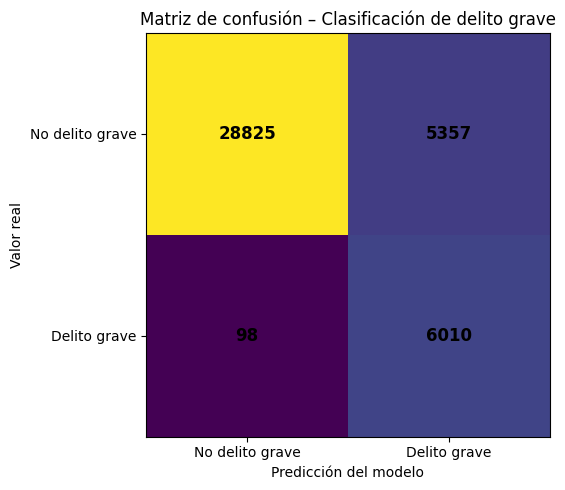

In [59]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["No delito grave", "Delito grave"]

fig, ax = plt.subplots(figsize=(6, 5))

im = ax.imshow(cm)

# Mostrar valores en cada celda
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i,
            cm[i, j],
            ha="center",
            va="center",
            fontsize=12,
            fontweight="bold"
        )

# Ejes y etiquetas
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

ax.set_xlabel("Predicción del modelo")
ax.set_ylabel("Valor real")
ax.set_title("Matriz de confusión – Clasificación de delito grave")

plt.tight_layout()
plt.show()
